## Train and stores embeddings

this colab loads a the code from git, trains GMM/GVAE model and stores the embeddings for further analysis



In [1]:
#@title Set up and imports
from google.colab import drive 
import os 

import tensorflow as tf
from tensorflow.python.keras import models
from tensorflow.python.keras.engine import node
from tensorflow.python.keras.engine.node import Node 
import tensorflow_probability as tfp
tfd = tfp.distributions

# notebook's location in the repo
WORKING_PATH = './drive/MyDrive/GGMbetaFactorVAE/GVAE/' 

if 'first_run' not in locals():
  drive.mount('/content/drive/')
  os.chdir(WORKING_PATH)

  first_run = False

Mounted at /content/drive/


In [3]:
from src.models import GM_VGAE, VGAE
from src import utils 

## Loading data 

In [4]:
## Loads data

network_path = 'data/diseasome/disease_network_adj.npy'
labels_path = 'data/diseasome/disease_network_types.npy'
output_path = 'data/saved/diseasome/model/'

data_params = dict(network_path = network_path,
                   labels_path = labels_path,
                   use_features=True,
                   auxiliary_prediction_task=True,
                   epochs=300)

adj, aux_targets, dataset = utils.load_and_build_dataset(data_params)

DONE: train_edges
DONE: test_edges_false
DONE: val_edges_false
True
True
True
True
True


## Defining a train step

In [5]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score


def get_roc_score(edges_pos, edges_neg, emb):

    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    # Predict on test set of edges
    adj_rec = np.dot(emb, emb.T)
    preds = []
    pos = []
    for e in edges_pos:
        preds.append(sigmoid(adj_rec[e[0], e[1]]))
        pos.append(adj_orig[e[0], e[1]])

    preds_neg = []
    neg = []
    for e in edges_neg:
        preds_neg.append(sigmoid(adj_rec[e[0], e[1]]))
        neg.append(adj_orig[e[0], e[1]])

    preds_all = np.hstack([preds, preds_neg])
    labels_all = np.hstack([np.ones(len(preds)), np.zeros(len(preds_neg))])
    roc_score = roc_auc_score(labels_all, preds_all)
    ap_score = average_precision_score(labels_all, preds_all)

    return roc_score, ap_score

In [6]:
def train_step(adj_normalized, features, adj_label, norm, pos_weight, experiment_params, aux_targets=None):   
    """ Defines basic training step """

    model_type = experiment_params['model']
    assert model_type in ['VGAE', 'GM_VGAE']
    assert ((model_type=='VGAE' and aux_targets is None) or (model_type=='GM_VGAE'))

    with tf.GradientTape() as tape:
        beta = 1
        adj_label = tf.reshape(adj_label, [-1])

        Q, Q_log_std, reconstructed = model(adj_normalized, features)
        reconstruction_loss = norm * tf.math.reduce_mean(
            tf.nn.weighted_cross_entropy_with_logits(labels=adj_label, logits=reconstructed, pos_weight=pos_weight)
        ) 

        if model_type == 'VGAE':
            kl = (0.5 / adj_label.shape[0]) * tf.math.reduce_mean(
                tf.math.reduce_sum(1 + 2 * Q_log_std - tf.math.square(Q.loc) - tf.math.square(Q.scale), axis=1)
            ) 
            # NOTE: why are these two different? they should give the same performance
            # kl = tf.reduce_mean(tfd.kl_divergence(Q, model.prior))
            classification_loss = 0
        else:
            kl = tf.reduce_mean(utils.mc_kl_divergence(Q, model.prior))
            # kl = tf.reduce_mean(kl_divergence_upper_bound(Q, model.prior))
            if experiment_params['auxiliary_prediction_task']:
                classification_loss = tf.reduce_mean(
                    tf.nn.softmax_cross_entropy_with_logits(logits=model.cy_logits, labels=aux_targets)
                )
                classification_accuracy = tf.reduce_mean(
                    tf.cast(tf.argmax(model.cy_logits, axis=1)==tf.argmax(aux_targets, axis=1), tf.float32), axis=0
                )
            else: 
                classification_loss = None
                classification_accuracy = None
        
        vae_loss = reconstruction_loss + beta*kl + classification_loss

    gradients = tape.gradient(vae_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    # metrics
    RECONSTRUCTION.append(reconstruction_loss.numpy())
    KL_LOSSES.append(kl.numpy())
    LOSSES.append(vae_loss.numpy())
    if experiment_params['auxiliary_prediction_task']:
        CLASSIFICATION_LOSSES.append(classification_loss.numpy())
        CLASSIFICATION_ACCURACIES.append(classification_accuracy.numpy())

## Experiment 

In [ ]:
## Initializes experiment 

experiment_params = dict(
    learning_rate=1e-3,
    epochs=data_params['epochs'],
    hidden=32,
    latent_size=16,
    dropout=0.2 ,
    model='GM_VGAE',
    use_features=data_params['use_features'],      
    auxiliary_prediction_task=data_params['auxiliary_prediction_task'],
    save_path=output_path 
)

# auxiliary prediction can only be done with GM_VAE
assert not (experiment_params['model']=='VGAE' and experiment_params['auxiliary_prediction_task'])

    
optimizer = tf.keras.optimizers.Adam(learning_rate=experiment_params['learning_rate'])
RECONSTRUCTION = []
KL_LOSSES = []
LOSSES = []
CLASSIFICATION_LOSSES = []
CLASSIFICATION_ACCURACIES = []

pos_weight = float(adj.shape[0] * adj.shape[0] - adj.sum()) / adj.sum()
norm = adj.shape[0] * adj.shape[0] / float((adj.shape[0] * adj.shape[0] - adj.sum()) * 2)

if experiment_params['auxiliary_prediction_task']: 
    class_num = aux_targets.shape[1]
else: 
    aux_targets = None 

node_num = adj.shape[0]

if experiment_params['model'] == 'VGAE':
    model = VGAE(node_num=node_num, 
                  hidden=experiment_params['hidden'], 
                  latent_size=experiment_params['latent_size'],
                  dropout=experiment_params['dropout'])
elif experiment_params['model'] == 'GM_VGAE':
    model = GM_VGAE(node_num=node_num, 
                    class_num=class_num, 
                    latent_size=experiment_params['latent_size'],
                    hidden=experiment_params['hidden'],
                    dropout=experiment_params['dropout'])


In [ ]:
#@title Training loop

e = 0
for adj_norm, features, label in dataset:
    train_step(adj_norm, features, 
               label, norm, pos_weight, 
               experiment_params, aux_targets=aux_targets)

    if e % 100 == 0:
        if experiment_params['auxiliary_prediction_task']:
            print(
                'total: {:.2f}, rec: {:.2f}, classification: {:.2f}, kl_loss: {:.2f}'.format(
                LOSSES[-1], RECONSTRUCTION[-1], CLASSIFICATION_ACCURACIES[-1], KL_LOSSES[-1]))
        else:
            print('total: {:.2f}, rec: {:.2f}, kl_loss: {:.2f}'.format(
                LOSSES[-1], RECONSTRUCTION[-1], KL_LOSSES[-1]))
    e +=1

total: 5.86, rec: 2.04, classification: 0.03, kl_loss: 0.72
total: 4.13, rec: 1.51, classification: 0.59, kl_loss: 0.20
total: 3.39, rec: 1.52, classification: 0.68, kl_loss: 0.24


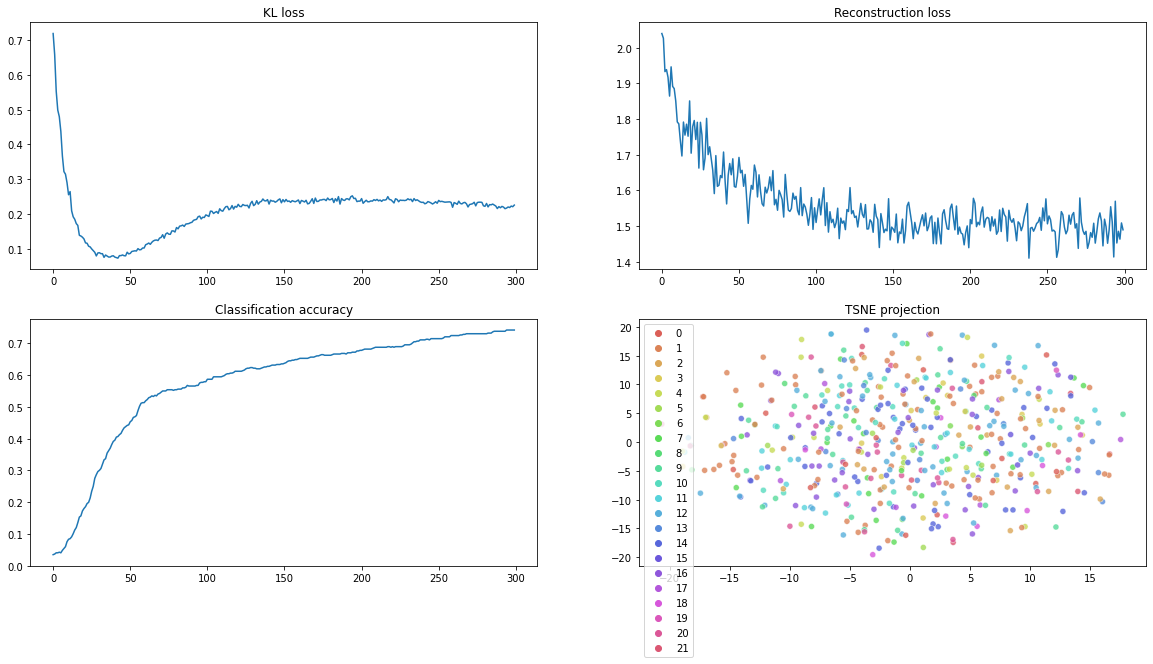

In [ ]:
#@title Diagnosis plots - 
#@markdown losses seem to be working as inteded but TSNE still doesn't not show 
#@markdown expected class clustering

import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.manifold import TSNE
import numpy as np


if experiment_params['model'] == 'GM_VGAE':
    Q = model.Q
    z = tf.squeeze(Q.sample(1))
else: 
    # z = model.
    print('nothing')
    
z_proj = TSNE(n_components=2).fit_transform(z)
    

fig, axs = plt.subplots(2, 2, figsize=(20, 10))
axs = axs.flatten()

axs[0].plot(KL_LOSSES)
axs[0].set_title('KL loss')

axs[1].plot(RECONSTRUCTION)
axs[1].set_title('Reconstruction loss')

if experiment_params['auxiliary_prediction_task']:
    # axs[2].plot(CLASSIFICATION_LOSSES)
    # axs[2].set_title('Classification loss')

    axs[2].plot(CLASSIFICATION_ACCURACIES)
    axs[2].set_title('Classification accuracy')

if 'z_proj' in locals():
    if experiment_params['auxiliary_prediction_task']:
        sns.scatterplot(
            x=z_proj[:, 0], y=z_proj[:, 1],
            palette=sns.color_palette("hls", aux_targets.shape[1]),
            hue=np.where(aux_targets==1)[1],
            legend='full', 
            alpha=0.8,
            ax=axs[3]
        )
    else:
        sns.scatterplot(
            x=z_proj[:, 0], y=z_proj[:, 1],
            legend='full', 
            alpha=0.8,
            ax=axs[3]
        )
    axs[3].set_title('TSNE projection')

In [ ]:
# saves model

## TODO generate save_path string from experiment params 
model.save_weights(experiment_params['save_path'])